## Preparation

In [2]:
twitter_database_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\databases\53k_individual_hcps_70_percent_confidence_tweets.db'
twitter_model_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\output_data\70_PERCENT_CONFIDENCE_53K_INDIVIDUAL_HCP_AUTHORS_2020_NO_KEYWORDS_WITH_RETWEETS_20_TOPICS'
#twitter_location_analysis_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\output_data\twitter_location_analysis\POI_Followers_13-06-20'
#sentiment_analysis_path = r'D:\iliapl\topic_modeling\data\output_data\twitter_sentiment_analysis\POI_Followers_13-06-20'
global_confirmed_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv'
global_death_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_global.csv'
us_confirmed_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_US.csv'
us_death_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_US.csv'

output_path = r'C:\Users\iliapl\Documents\CoronaVirusProject\data\output_data\twitter_over_time\53k_individual_hcps'

In [3]:
start_date = (1, 1, 2019)
end_date = (6, 12, 2020)

NUM_TOPICS = 20

In [4]:
from gensim.corpora import Dictionary
from gensim.corpora.mmcorpus import MmCorpus
from gensim.models import LdaModel
import time

# Load corpus, dictionary and model

T = time.time()

twitter_corpus = MmCorpus('{}/corpus.mm'.format(twitter_model_path))
twitter_dict = Dictionary.load('{}/dict.id2word'.format(twitter_model_path))
twitter_model = LdaModel.load('{}/lda.model'.format(twitter_model_path))

T = time.time() - T
print('Loaded twitter model, corpus, dictionary in {} seconds'.format(T))

Loaded twitter model, corpus, dictionary in 3.5427117347717285 seconds


In [ ]:
import json

# Load tweet id to bag-of-words map

T = time.time()
with open('{}/post_id_bow_dict.json'.format(twitter_model_path), 'r') as json_file:
    tweet_id_dict = json.load(json_file)
    
T = time.time() - T
print('Loaded id -> bow dictionary in {} seconds'.format(T))

In [5]:
import sqlite3 as sql
import os

# Load or create tweet_id -> date map

if not os.path.exists(output_path):
    os.makedirs(output_path)

T = time.time()

if not os.path.isfile('{}/tweet_date_map.json'.format(twitter_model_path)):
    conn = sql.connect(twitter_database_path)
    cur = conn.cursor()
    query = 'SELECT post_id, date FROM posts'
    tweet_id_dates = cur.execute(query).fetchall()
    tweet_id_date_dict = {tweet_id : date for (tweet_id, date) in tweet_id_dates if tweet_id in tweet_id_dict}
    with open('{}/tweet_date_map.json'.format(twitter_model_path), 'w') as file_handle:
        json.dump(tweet_id_date_dict, file_handle)
else:
    with open('{}/tweet_date_map.json'.format(twitter_model_path), 'r') as file_handle:
        tweet_id_date_dict = json.load(file_handle)


T = time.time() - T
print('Loaded id -> date dictionary in {} seconds'.format(T))

Loaded id -> date dictionary in 9.236401319503784 seconds


In [6]:
import ast

# Load or create tweet_id -> topic map

T = time.time()

tweet_id_topic_dict = {}

if not os.path.isfile('{}/tweet_topic_map.json'.format(twitter_model_path)):
    for tweet_id, bow in tweet_id_dict.items():
        topics = twitter_model.get_document_topics(bow)
        tweet_id_topic_dict[tweet_id] = max(topics, key=lambda tup: tup[1])
        
        # so we can save it as json
        tweet_id_topic_dict[tweet_id] = (tweet_id_topic_dict[tweet_id][0], round(tweet_id_topic_dict[tweet_id][1], 3))
    with open('{}/tweet_topic_map.json'.format(twitter_model_path), 'w') as file_handle:
        json.dump({tweet_id : str(topic) for (tweet_id, topic) in tweet_id_topic_dict.items()}, file_handle)
else:
    with open('{}/tweet_topic_map.json'.format(twitter_model_path), 'r') as file_handle:
        tweet_id_topic_dict = json.load(file_handle)
        tweet_id_topic_dict = {tweet_id : ast.literal_eval(tup_str) for (tweet_id, tup_str) in tweet_id_topic_dict.items()}
    
T = time.time() - T
print('Loaded id -> topic dictionary in {} seconds'.format(T))

Loaded id -> topic dictionary in 233.15202593803406 seconds


In [7]:
import os

T = time.time()

# Load or create tweet_id -> author name map

tweet_id_author_dict = {}

if not os.path.isfile('{}/tweet_author_map.json'.format(twitter_model_path)):
    cur = conn.cursor()
    query = 'SELECT post_id, author FROM posts WHERE post_id IN {}'.format(str(tuple(list(tweet_id_topic_dict.keys()))))
    results = cur.execute(query).fetchall()
    tweet_id_author_dict = {result[0] : result[1] for result in results}
    with open('{}/tweet_author_map.json'.format(twitter_model_path), 'w') as file_handle:
        json.dump(tweet_id_author_dict, file_handle)
else:
    with open('{}/tweet_author_map.json'.format(twitter_model_path), 'r') as file_handle:
        tweet_id_author_dict = json.load(file_handle)
    
T = time.time() - T
print('Loaded id -> author dictionary in {} seconds'.format(T))

Loaded id -> author dictionary in 19.153240203857422 seconds


In [8]:
tweet_id_country_dict = {}

# Load tweet_id -> country map

with open('{}/tweet_countries.json'.format(twitter_location_analysis_path), 'r') as file_handle:
    tweet_id_country_dict = json.load(file_handle)

In [9]:
tweet_id_state_dict = {}

# Load tweet_id -> state map

with open('{}/tweet_states.json'.format(twitter_location_analysis_path), 'r') as file_handle:
    tweet_id_state_dict = json.load(file_handle)

In [10]:
tweet_id_sentiment_dict = {}

# Load tweet_id -> sentiment value map

with open('{}/tweet_id_sentiment_map.json'.format(sentiment_analysis_path), 'r') as file_handle:
    tweet_id_sentiment_dict = json.load(file_handle)

In [11]:
import datetime

# covid data starts on 22/01
covid_data_start_date_obj = max(datetime.date(start_date[2], start_date[1], start_date[0]), datetime.date(2020, 1, 22))

covid_data_end_date_obj = datetime.date(end_date[2], end_date[1], end_date[0])

In [12]:
with open('{}/state_code_name.json'.format(twitter_location_analysis_path), 'r') as file_handle:
    state_code_name_dict = json.load(file_handle)

state_name_code_dict = {state_name : state_code for (state_code, state_name) in state_code_name_dict.items()}

In [13]:
import pandas as pd

global_confirmed_df = pd.read_csv(global_confirmed_path)
global_death_df = pd.read_csv(global_death_path)
us_confirmed_df = pd.read_csv(us_confirmed_path)
us_death_df = pd.read_csv(us_death_path)

In [14]:
import numpy as np

def get_new_cases_per_day(case_type, country_name, state, covid_data_start_date, end_date):
    if case_type != 'confirmed' and case_type != 'death':
        print('Valid cases are confirmed and death')
        
    if case_type == 'confirmed':
        if state:
            df = us_confirmed_df
        else:
            df = global_confirmed_df
    elif case_type == 'death':
        if state:
            df = us_death_df
        else:
            df = global_death_df
        
    series = []
    
    start_date = covid_data_start_date
    delta = datetime.timedelta(days=1)

    date = start_date
    
    while date <= end_date:
        
        date_str = date.strftime('%m/%d/%y').lstrip("0").replace("/0", "/")    
        previous_day_str = (date - delta).strftime('%m/%d/%y').lstrip('0').replace('/0', '/')
        
        if country_name == 'global':
            series.append(sum(df[date_str]) - sum(df[previous_day_str]))
        else:
            column_name = 'Country/Region' if not state else 'Province_State'
            row = df.loc[df[column_name] == country_name]
            
            # sum is applied because some countries (like UK) have provinces, creating duplicate country names
            daily_count = int(sum(row[date_str]) - sum(row[previous_day_str]))
            series.append(daily_count)
                
        date += delta
    return series

In [15]:
from tqdm import tqdm

def get_tweets_per_day(country_name, state, topic_id, start_date, end_date):
    if topic_id != -1:
        tweet_ids = [tweet_id for (tweet_id, tweet_topic) in tweet_id_topic_dict.items() if tweet_topic[0] == topic_id]
    else:
        tweet_ids = [tweet_id for (tweet_id, _) in tweet_id_topic_dict.items()]
    tweets_per_day = []
    delta = end_date - start_date
    num_days = delta.days
    
    for i in range(num_days + 1):
        tweets_per_day.append([])
    
    print('Getting tweets per day for {} (state: {}), topic id: {}, start_date: {}, end_date: {}'.format(country_name,
                                                                                                        state, topic_id,
                                                                                                        start_date, end_date))
    for tweet_id in tweet_ids:
        if tweet_id not in tweet_id_date_dict:
            continue
        tweet_date = tweet_id_date_dict[tweet_id]
        tweet_date = tweet_date[:tweet_date.index(' ')] # keep just the date, without time, ,%Y-%m-%d
        date_obj = datetime.datetime.strptime(tweet_date, '%Y-%m-%d').date()
        if start_date <= date_obj <= end_date:
            day_idx = (date_obj - start_date).days
            tweets_per_day[day_idx].append(tweet_id)
    
    if country_name != 'global':
        country_state_dict = tweet_id_country_dict
        if state:
            country_name = state_name_code_dict.get(country_name, None)
            if country_name is None or country_name not in set(tweet_id_state_dict.values()):
                raise ValueError('Invalid state name')
                return None
            
            # country_name is the name of a state
            country_state_dict = tweet_id_state_dict
            
        country_tweets_per_day = []
        for day_tweets in tweets_per_day:
            new_day_tweets = []
            for tweet in day_tweets:
                if tweet in country_state_dict and country_state_dict[tweet] == country_name:
                    new_day_tweets.append(tweet)
            country_tweets_per_day.append(new_day_tweets)
        tweets_per_day = country_tweets_per_day
    
    return tweets_per_day

In [16]:
def get_num_different_authors(tweet_list):
    return len(set([tweet_id_author_dict[tweet_id] for tweet_id in tweet_list]))

In [17]:
def get_num_tweets_per_day(country_name, state, topic_id, start_date, end_date, num_distinct_authors=False):
    tweets_per_day = get_tweets_per_day(country_name, state, topic_id, start_date, end_date)
    num_different_authors = None
    if get_num_different_authors:
        num_different_authors = [get_num_different_authors(daily_tweets) for daily_tweets in tweets_per_day]
    return [len(lst) for lst in tweets_per_day], num_different_authors

## Sentiment Over Time

In [18]:
def get_percentile_values(value_list, min_max, percentile):
    num_values_to_retrieve = int(percentile / 100 * len(value_list))
    if num_values_to_retrieve == 0:
        print('Percentile too low, not enough values')
        return None
    if min_max.lower() == 'min':
        return sorted(value_list)[:num_values_to_retrieve]
    else:
        return sorted(value_list, reverse=True)[:num_values_to_retrieve]

In [19]:
def get_sentiment_aggregate(tweet_id_list, aggregate_type, min_max_percentile):
    sentiments = [tweet_id_sentiment_dict[tweet_id] for tweet_id in tweet_id_list if tweet_id in tweet_id_sentiment_dict]
    if aggregate_type == 'average':
        return sum(sentiments) / len(sentiments)
    else:
        values = get_percentile_values(sentiments, aggregate_type, min_max_percentile)
        return sum(values) / len(values)

In [20]:
def get_weekly_sentiment_aggregate(country_name, state, topic_id, start_date, end_date, aggregate_type, min_max_percentile, tweets_per_day=None):
    if not tweets_per_day:
        tweets_per_day = get_tweets_per_day(country_name, state, topic_id, start_date, end_date)
    sentiments_per_day = [get_sentiment_aggregate(daily_tweets, aggregate_type, min_max_percentile) if len(daily_tweets) > 0 else 0 for daily_tweets in tweets_per_day]
    divided_list = [sentiments_per_day[x:x+7] for x in range(0, len(sentiments_per_day), 7)]
    if aggregate_type == 'average':
        weekly_values = [sum(lst) / len(lst) for lst in divided_list]
    elif aggregate_type == 'max':
        weekly_values = [max(lst) for lst in divided_list]
    elif aggregate_type == 'min':
        weekly_values = [min(lst) for lst in divided_list]
    return weekly_values

In [21]:
def get_flattened_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [22]:
def get_normalized(lst):
    new_lst = []
    for i in lst:
        new_lst.append(i / max(lst))
    return new_lst

In [23]:
def get_weekly_counts_by_days(daily_count_list):
    divided_list = [daily_count_list[x:x+7] for x in range(0, len(daily_count_list), 7)]
    weekly_counts = [sum(lst) for lst in divided_list]
    return weekly_counts

In [24]:
def get_sentiment_count(tweet_list, non_neutral_threshold=0.05):
    negative = 0
    neutral = 0
    positive = 0
    for tweet in tweet_list:
        if tweet not in tweet_id_sentiment_dict:
            continue
        sentiment = tweet_id_sentiment_dict[tweet]
        if sentiment < -non_neutral_threshold:
            negative += 1
        elif sentiment > non_neutral_threshold:
            positive += 1
        else:
            neutral += 1
    return (negative, neutral, positive)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

def plot_weekly_sentiment_stacked_area_chart(country_name, state, topic_id, start_date, end_date, non_neutral_threshold=0.05):
    tweets_per_day = get_tweets_per_day(country_name, state, topic_id, start_date, end_date)

    divided_list = [get_flattened_list(tweets_per_day[x:x+7]) for x in range(0, len(tweets_per_day), 7)]
    num_weeks = len(divided_list)
    df_dict = {'negative' : [], 'neutral' : [], 'positive' : []}
    
    for i, weekly_tweets in enumerate(divided_list):
        sentiment_count = get_sentiment_count(weekly_tweets, non_neutral_threshold=non_neutral_threshold)
        current_week = start_date + datetime.timedelta(days=7*i)
        df_dict['negative'].append(sentiment_count[0])
        df_dict['neutral'].append(sentiment_count[1])
        df_dict['positive'].append(sentiment_count[2])
        
    df = pd.DataFrame(df_dict, index=[start_date + datetime.timedelta(days=7*i) for i in range(num_weeks)])
    df = df.divide(df.sum(axis=1), axis=0)
    
    mpl.rcParams['font.size'] = 15.0
    
    plot = df.plot.area(figsize=(18, 10), linewidth=1, colormap='gray')
    plot.collections[0].set_facecolor('#ff0000')
    plot.collections[0].set_edgecolor('#ff0000')
    plot.collections[1].set_facecolor('#eda51d')
    plot.collections[1].set_edgecolor('#eda51d')
    plot.collections[2].set_facecolor('#77d750')
    plot.collections[2].set_edgecolor('#77d750')
    
    leg = plot.legend(['Negative tweets', 'Neutral tweets', 'Positive tweets'], loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=True, ncol=3)
    leg.legendHandles[0].set_color('#ff0000')
    leg.legendHandles[1].set_color('#eda51d')
    leg.legendHandles[2].set_color('#77d750')
    
    fig = plot.get_figure()

    plt.margins(0, 0)
    plt.autoscale()
    
    ax = plot.axes
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
   
    ax.axvline(datetime.date(2020, 3, 5), 0, 1.0, color='grey', ls='--')
    ax.text(datetime.date(2020, 3, 5), 0.2, 'March 5th - First case in U.S.', rotation=90)

    ax.axvline(datetime.date(2020, 5, 22), 0, 1.0, color='grey', ls='--')
    ax.text(datetime.date(2020, 5, 22), 0.2, 'May 22nd - Dominic Cummings scandal', rotation=90)
    
    ax.axvline(datetime.date(2020, 5, 25), 0, 1.0, color='grey', ls='--')
    ax.text(datetime.date(2020, 5, 25), 0.2, 'May 25th - Death of George Floyd', rotation=90)
    
    #if country_name != 'global':
    #    plt.title('Weekly tweet sentiment for {} in {} - threshold {}'.format('topic {}'.format(topic_id) if topic_id != -1 else 'all topics',
    #                                                      country_name, non_neutral_threshold))
    #else:
    #    plt.title('Global weekly tweet sentiment for {} - threshold {}'.format('topic {}'.format(topic_id) if topic_id != -1 else 'all topics', non_neutral_threshold))
        
        
    fig.autofmt_xdate()

    fig.savefig('test.png', bbox_inches='tight')

In [ ]:
plot_weekly_sentiment_stacked_area_chart('global', False, -1, datetime.date(start_date[2], start_date[1], start_date[0]),
                                         covid_data_end_date_obj, non_neutral_threshold=0.2)

In [ ]:
from scipy.stats import pearsonr
from math import ceil

def plot_weekly_sentiment_aggregate(country_name, state, topic_id, start_date, end_date, aggregate_types, min_max_percentile):
    weekly_aggregate_dict = {}
    tweets_per_day = get_tweets_per_day(country_name, state, topic_id, start_date, end_date)
    for aggregate_type in aggregate_types:
        weekly_aggregate_dict[aggregate_type] = get_weekly_sentiment_aggregate(country_name, state, topic_id, covid_data_start_date_obj, covid_data_end_date_obj, 
                                                                               aggregate_type, min_max_percentile, tweets_per_day=tweets_per_day)    
    if country_name == 'United States':
        country_name = 'US'
        
    infected_per_day = get_new_cases_per_day('confirmed', country_name, state, start_date, end_date)
    infected_per_week = get_weekly_counts_by_days(infected_per_day)
    dead_per_day = get_new_cases_per_day('death', country_name, state, start_date, end_date)
    dead_per_week = get_weekly_counts_by_days(dead_per_day)
    
    for aggregate_type in aggregate_types:
        correlation_value, pvalue = pearsonr(infected_per_week, weekly_aggregate_dict[aggregate_type])
        print('Confirmed {} case correlation: {:.3}, p-value: {:.3}'.format(aggregate_type, correlation_value, pvalue))
        correlation_value, pvalue = pearsonr(dead_per_week, weekly_aggregate_dict[aggregate_type])
        print('Death {} case correlation: {:.3}, p-value: {:.3}'.format(aggregate_type, correlation_value, pvalue))
    
    date_range = pd.date_range(start_date, end_date)
    num_weeks = ceil(len(date_range) / 7)
    
    fig, ax = plt.subplots(figsize=(17, 8))

    for i, aggregate_type in enumerate(aggregate_types):
        if aggregate_type == 'min':
            label = 'Average bottom 10% sentiment'
            color = 'red'
        elif aggregate_type == 'average':
            label = 'Total average sentiment'
            color = 'orange'
        elif aggregate_type == 'max':
            label = 'Average top 10% sentiment'
            color = 'green'
        plt.plot([start_date + datetime.timedelta(days=7*i) for i in range(num_weeks)], weekly_aggregate_dict[aggregate_type],
                 label=label, color=color)


    leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=True, ncol=3)
    
    plt.ylabel('Sentiment')
   
    #if country_name != 'global':
    #    plt.title('Weekly aggregated sentiment for {} in {}'.format('all topics' if topic_id == -1 else 'topic {}'.format(topic_id),
    #                                                          country_name))
    #else:
    #    plt.title('Global weekly aggregated sentiment for {}'.format('all topics' if topic_id == -1 else 'topic {}'.format(topic_id)))
    
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
    fig.autofmt_xdate()


In [ ]:
plot_weekly_sentiment_aggregate('global', False, -1, covid_data_start_date_obj + datetime.timedelta(days=1), covid_data_end_date_obj, ['max', 'average', 'min'], 10)

## Tweet Count Time Series

In [25]:
from IPython.display import display
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def prepare_topic_country_tweet_count_over_time(country_name, state, topic_id, start_date, end_date, show_infected_graph=True,
                                                show_death_graph=True, show_distinct_author_graph=True, normalize=False, weekly=True):
    
    if topic_id != -1:
        img = Image.open('{}/topic{}.png'.format(twitter_model_path, topic_id))
        img.thumbnail((150, 150))
        display(img)
    
    num_tweets_per_day, num_distinct_authors_per_day = get_num_tweets_per_day(country_name, state, topic_id, start_date, end_date,
                                                                             num_distinct_authors=show_distinct_author_graph)
    if not weekly:
        num_tweets_per_time_period = num_tweets_per_day
        num_authors_per_time_period = num_distinct_authors_per_day
    else:
        num_tweets_per_time_period = get_weekly_counts_by_days(num_tweets_per_day)
        num_authors_per_time_period = get_weekly_counts_by_days(num_distinct_authors_per_day)
        
        
    normalized_num_tweets_per_time_period = get_normalized(num_tweets_per_time_period)

    fig, ax = plt.subplots(figsize=(15, 7))
    date_range = pd.date_range(start_date, end_date)
    if weekly:
        date_range = [str(date_range[i]) for i in range(0, len(date_range), 7)]
    plt.plot(date_range, normalized_num_tweets_per_time_period if normalize else num_tweets_per_time_period, 
             label='{} tweet count'.format('Weekly' if weekly else 'Daily'))

    if country_name == 'United States':
        country_name = 'US'
        
    if show_infected_graph:
        if start_date < datetime.date(2020, 1, 23):
            raise ValueError('COVID-19 cases per day data starts on 22/01/2020, adjust start date accordingly')
        infected_per_day = get_new_cases_per_day('confirmed', country_name, state, start_date, end_date)
        if weekly:
            infected_per_time_period = get_weekly_counts_by_days(infected_per_day)
        else:
            infected_per_time_period = list(map(lambda a: np.nan if a < 0 else a, infected_per_day))
                    
        normalized_infected_per_time_period = get_normalized(infected_per_time_period)
        
        no_nan_infected_per_time_period = [number if number == number else 0 for number in infected_per_time_period]
        correlation_value, pvalue = pearsonr(num_tweets_per_time_period, no_nan_infected_per_time_period)
        print('Confirmed case correlation: {:.3}, p-value: {:.3}'.format(correlation_value, pvalue))
        plt.plot(date_range, normalized_infected_per_time_period if normalize else infected_per_time_period, 
                 label='{} confirmed cases'.format('Weekly' if weekly else 'Daily'))
    
    if show_death_graph:
        if start_date < datetime.date(2020, 1, 23):
            raise ValueError('COVID-19 cases per day data starts on 22/01/2020, adjust start date accordingly')
        deaths_per_day = get_new_cases_per_day('death', country_name, state, start_date, end_date)
        if weekly:
            deaths_per_time_period = get_weekly_counts_by_days(deaths_per_day)
        else:
            deaths_per_time_period = list(map(lambda a: np.nan if a < 0 else a, deaths_per_day))
        normalized_deaths_per_time_period = get_normalized(deaths_per_time_period)
        
        no_nan_deaths_per_time_period = [number if number == number else 0 for number in deaths_per_time_period]
        correlation_value, pvalue = pearsonr(num_tweets_per_time_period, no_nan_deaths_per_time_period)
        print('Death case correlation: {:.3}, p-value: {:.3}'.format(correlation_value, pvalue))
        plt.plot(date_range, normalized_deaths_per_time_period if normalize else deaths_per_time_period,
                 'r', label='{} deaths'.format('Weekly' if weekly else 'Daily'))
        
    if show_distinct_author_graph:
        normalized_num_distinct_authors_per_time_period = get_normalized(num_authors_per_time_period)
        
        plt.plot(date_range, normalized_num_distinct_authors_per_time_period if normalize else
                num_authors_per_time_period, label='# distinct authors')
    if not weekly:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
        
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
        
    plt.title('{}Tweet count per {} for {} in {}'.format('Normalized ' if normalize else '', 
                                                          'Week' if weekly else 'Day',
                                                         'topic {}'.format(topic_id) if topic_id != -1 else 'all topics',
                                                          country_name))
    plt.ylabel('{}{} item count'.format('Normalized ' if normalize else '', 'Weekly' if weekly  else 'Daily'))

In [ ]:
prepare_topic_country_tweet_count_over_time('global', False, 8, covid_data_start_date_obj + datetime.timedelta(days=1), covid_data_end_date_obj,
                                            show_infected_graph=True, show_death_graph=True, show_distinct_author_graph=True,
                                            normalize=False, weekly=True)
plt.show()

## Correlation matrices

In [27]:
from scipy.stats import pearsonr

def generate_weekly_correlation_matrix(country_name, state, start_date, end_date):
    df_dict = {}
    for topic_id in range(NUM_TOPICS):
        num_tweets_per_day = get_num_tweets_per_day(country_name, state, topic_id, start_date, end_date)[0]
        num_confirmed_per_day = get_new_cases_per_day('confirmed', country_name if country_name != 'United States' else 'US'
                                                      , state, start_date, end_date)
        num_dead_per_day = get_new_cases_per_day('death', country_name if country_name != 'United States' else 'US'
                                                 , state, start_date, end_date)

        num_tweets_per_week = get_weekly_counts_by_days(num_tweets_per_day)
        num_confirmed_per_week = get_weekly_counts_by_days(num_confirmed_per_day)
        num_dead_per_week = get_weekly_counts_by_days(num_dead_per_day)
        
        confirmed_correlation_pvalue = pearsonr(num_tweets_per_week, num_confirmed_per_week)
        confirmed_delta_correlation_pvalue = pearsonr([num_tweets_per_week[i] - num_tweets_per_week[i-1] for i in range(1, len(num_tweets_per_week))]
                                                     , [num_confirmed_per_week[i] - num_confirmed_per_week[i-1] for i in range(1, len(num_confirmed_per_week))])
        death_correlation_pvalue = pearsonr(num_tweets_per_week, num_dead_per_week)
        death_delta_correlation_pvalue = pearsonr([num_tweets_per_week[i] - num_tweets_per_week[i-1] for i in range(1, len(num_tweets_per_week))]
                                                     , [num_dead_per_week[i] - num_dead_per_week[i-1] for i in range(1, len(num_dead_per_week))])
        df_dict['t{}'.format(topic_id)] = [confirmed_correlation_pvalue[0], confirmed_correlation_pvalue[1],
                                           confirmed_delta_correlation_pvalue[0], confirmed_delta_correlation_pvalue[1],
                                           death_correlation_pvalue[0], death_correlation_pvalue[1],
                                          death_delta_correlation_pvalue[0], death_delta_correlation_pvalue[1]]
        
    df = pd.DataFrame(df_dict, index=['confirmed', 'confirmed p-value', 'confirmed deltas', 'confirmed deltas p-value',
                                      'deaths', 'deaths p-value', 'death deltas', 'death deltas p-value'])
    if not os.path.exists('{}/correlation'.format(output_path)):
        os.makedirs('{}/correlation'.format(output_path))
    df.to_csv('{}/correlation/{}.csv'.format(output_path, country_name))
    return df

In [34]:
for country_name, is_state in [('United States', False), ('Canada', False), ('Saudi Arabia', False), ('India', False), ('Mexico', False),
                              ('New York', True), ('Texas', True), ('Florida', True), ('Massachusetts', True)]: 
    generate_weekly_correlation_matrix(country_name, is_state, covid_data_start_date_obj + datetime.timedelta(days=1), covid_data_end_date_obj)

In [26]:
def get_topic_volume_correlation_matrix(country_name, state, start_date, end_date):
    T = time.time()
    weekly_tweet_volumes = [get_weekly_topic_volume(country_name, state, topic_id, start_date, end_date) for topic_id in range(NUM_TOPICS)]
    print('Got weekly tweet volumes for all topics in {} seconds'.format(time.time() - T))
    
    correlation_dict = {}
    for i in range(NUM_TOPICS):
        correlation_dict[(i, i)] = 1
        for j in range(i + 1, NUM_TOPICS):
            correlation_value, _ = pearsonr(weekly_tweet_volumes[i], weekly_tweet_volumes[j])
            correlation_dict[(i, j)] = correlation_value
            correlation_dict[(j, i)] = correlation_dict[(i, j)]
    df_dict = {'t{}'.format(i) : [correlation_dict[(i, j)] for j in range(NUM_TOPICS)] for i in range(NUM_TOPICS)}
    
    df = pd.DataFrame(df_dict, index=['t{}'.format(i) for i in range(NUM_TOPICS)])
    df.to_csv('{}/correlation/volumes-{}.csv'.format(output_path, country_name))
    return df

In [27]:
df = get_topic_volume_correlation_matrix('global', False, covid_data_start_date_obj, covid_data_end_date_obj)

Got weekly tweet volumes for all topics in 1568.9715218544006 seconds


# Stacked area charts of global topics

In [25]:
import datetime

def get_topic_tweets_per_week(model, corpus, topic, start_day, start_month, start_year, end_day, end_month, end_year):
    delta = datetime.timedelta(days=6)
    
    all_week_tweets = []
    
    start_date = datetime.date(start_year, start_month, start_day)
    end_date = datetime.date(end_year, end_month, end_day)
    current_date = start_date
    
    while current_date <= end_date:
        
        end_of_week = min(current_date + delta, end_date)
        
        # flatten list of daily tweets
        all_week_tweets.append([tweet for day_tweets in get_tweets_per_day('global', False, topic,
                                current_date, end_of_week)
                                for tweet in day_tweets])
        
        current_date += (delta + datetime.timedelta(days=1))
    return all_week_tweets
        

In [55]:
topics_to_show = [0, 1, 2, 3, 4, 5, 8, 9]
topic_colors = {0: 'navy', 1: 'red', 2: 'brown', 3: 'dodgerblue', 4: 'lime', 5: 'blue', 8: 'purple', 9: 'orange', 16: 'green'}
topic_names = {0: 'everyday life', 1: 'call for action', 2: 'online education', 3: 'interracial tension', 4: 'epidemiological information', 5: 'PPE for healthcare professionals', 8: 'leisure and art', 9: 'well-wishing'}

In [27]:
tweets_per_topic_per_week = {}
for topic in topics_to_show:
    tweets_per_topic_per_week[topic] = get_topic_tweets_per_week(twitter_model, twitter_corpus, topic, *start_date, *end_date)

Getting tweets per day for global (state: False), topic id: 0, start_date: 2019-12-31, end_date: 2020-01-06
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-01-07, end_date: 2020-01-13
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-01-14, end_date: 2020-01-20
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-01-21, end_date: 2020-01-27
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-01-28, end_date: 2020-02-03
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-02-04, end_date: 2020-02-10
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-02-11, end_date: 2020-02-17
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-02-18, end_date: 2020-02-24
Getting tweets per day for global (state: False), topic id: 0, start_date: 2020-02-25, end_date: 2020-03-02
Getting tweets per day for g

Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-01-28, end_date: 2020-02-03
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-02-04, end_date: 2020-02-10
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-02-11, end_date: 2020-02-17
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-02-18, end_date: 2020-02-24
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-02-25, end_date: 2020-03-02
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-03-03, end_date: 2020-03-09
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-03-10, end_date: 2020-03-16
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-03-17, end_date: 2020-03-23
Getting tweets per day for global (state: False), topic id: 3, start_date: 2020-03-24, end_date: 2020-03-30
Getting tweets per day for g

Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-02-25, end_date: 2020-03-02
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-03-03, end_date: 2020-03-09
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-03-10, end_date: 2020-03-16
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-03-17, end_date: 2020-03-23
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-03-24, end_date: 2020-03-30
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-03-31, end_date: 2020-04-06
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-04-07, end_date: 2020-04-13
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-04-14, end_date: 2020-04-20
Getting tweets per day for global (state: False), topic id: 8, start_date: 2020-04-21, end_date: 2020-04-27
Getting tweets per day for g

In [28]:
tweet_count_per_topic_per_week = {topic_id: [len(weekly_tweets) for weekly_tweets in topic_week_tweets] for topic_id, topic_week_tweets in tweets_per_topic_per_week.items()}

In [29]:
from PIL import Image

def add_topic_labels(fig, id_location_size_map):
    for topic_id, (location, size) in id_location_size_map.items():
        img = Image.open('{}/topic{}.png'.format(twitter_model_path, topic_id))
        img.thumbnail(size)
        fig.figimage(img, *location)

In [30]:
len(tweet_id_topic_dict)

5482094

In [31]:
import pandas as pd

num_weeks = len(list(tweet_count_per_topic_per_week.items())[0][1])
start_date_obj = datetime.date(*(reversed(start_date)))
d = {'t{}'.format(i) : tweet_count_per_topic_per_week[i] for i in topics_to_show}
df = pd.DataFrame(d, index=[start_date_obj + datetime.timedelta(days=i*7) for i in range(num_weeks)])
df.to_csv('{}/tweet_topic_count_per_week.csv'.format(output_path))

relative_df = df.divide(df.sum(axis=1), axis=0)

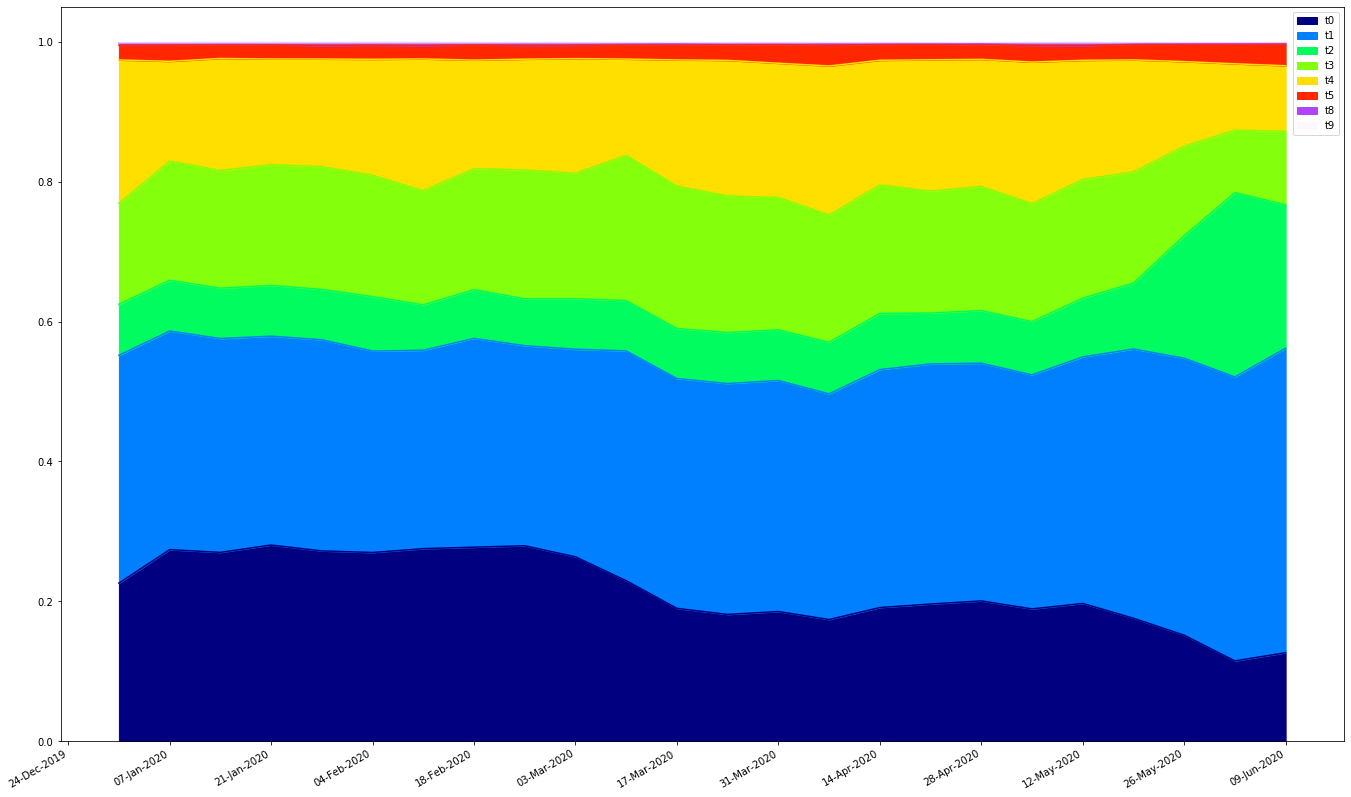

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox


plot = relative_df.plot.area(figsize=(23, 15), colormap='gist_ncar')
fig = plot.get_figure()
    
ax = plot.axes
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))

fig.autofmt_xdate()

id_location_size_map = {}
add_topic_labels(fig, id_location_size_map)
fig.savefig('{}/tweet_topic_count_per_week.png'.format(output_path))

## Topic Volume with Sorted Sentiment

In [33]:
from math import ceil

start_date_obj = datetime.date(start_date[2], start_date[1], start_date[0])
x = pd.date_range(start_date_obj, datetime.date(end_date[2], end_date[1], end_date[0]))
num_weeks = ceil(len(x) / 7)
x = [start_date_obj + datetime.timedelta(days=7*i) for i in range(num_weeks)]

Getting tweets per day for global (state: False), topic id: 0, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 1, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 2, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 3, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 4, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 5, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 8, start_date: 2019-12-31, end_date: 2020-06-13
Getting tweets per day for global (state: False), topic id: 9, start_date: 2019-12-31, end_date: 2020-06-13


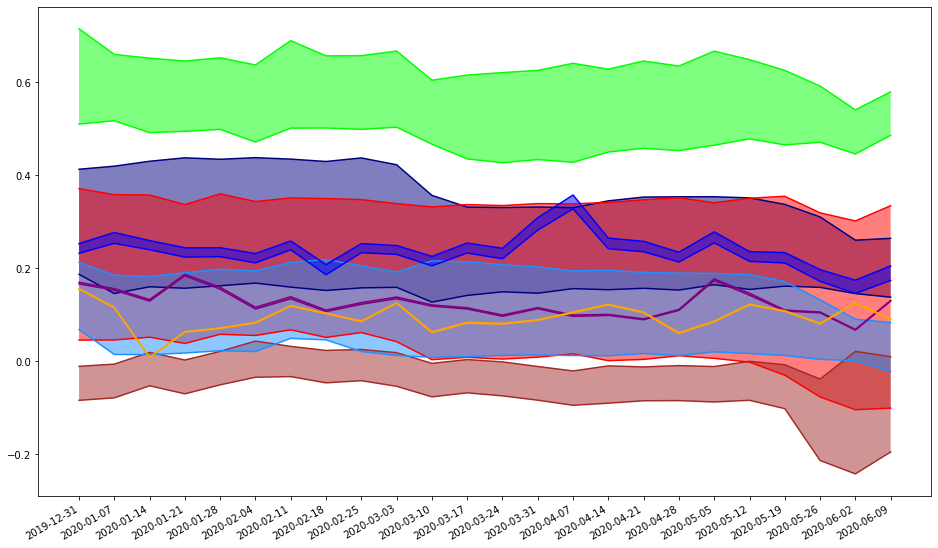

In [34]:
fig, ax = plt.subplots(figsize=(16, 10))
ax = plot.axes

for topic in topics_to_show:
    sentiment_values = np.array(get_weekly_sentiment_aggregate('global', False, topic, datetime.date(start_date[2], start_date[1], start_date[0]),
                               datetime.date(end_date[2], end_date[1], end_date[0]), 'average', 0.2, tweets_per_day=None))
    topic_volume = np.array(relative_df[f't{topic}'])
    
    Y = sentiment_values - topic_volume / 2
    Y1 = sentiment_values + topic_volume / 2
    
    plt.fill_between(x, Y, Y1, where=Y1>=Y, facecolor=topic_colors[topic], interpolate=True, alpha=0.5)
    plt.plot(x, Y, c=topic_colors[topic])
    plt.plot(x, Y1, c=topic_colors[topic])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))

plt.xticks(x)

fig.autofmt_xdate()
plt.show()

## Ordered Streamgraph

In [56]:
topics_to_show = [0, 1, 2, 3, 4, 5, 8, 9]

In [57]:
# sort topics by average sentiment

topic_sentiments = {}
average_topic_sentiment = {}

for tweet, sentiment in tqdm(tweet_id_sentiment_dict.items()):
    if tweet not in tweet_id_topic_dict:
        continue
    topic_id = tweet_id_topic_dict[tweet][0]
    if topic_id in topics_to_show:
        if topic_id in topic_sentiments:
            topic_sentiments[topic_id].append(sentiment)
        else:
            topic_sentiments[topic_id] = [sentiment]

100%|██████████████████████████| 17817582/17817582 [00:34<00:00, 521610.60it/s]


In [58]:
average_topic_sentiment = {topic_id: np.mean(sentiment_list) for topic_id, sentiment_list in topic_sentiments.items()}

In [59]:
average_topic_sentiment

{0: 0.2628537589336674,
 3: 0.09551235931094228,
 2: -0.09650626652181786,
 8: 0.14432893183472142,
 1: 0.146866868913489,
 4: 0.531460820578768,
 5: 0.23048950168687452,
 9: 0.09773459060402685}

In [60]:
sorted_topics_descending = [topic for (topic, _) in sorted(list(average_topic_sentiment.items()), key=lambda tup: tup[1], reverse=True)]

In [61]:
import colorsys
import numpy as np

# colorsys - hue of red = 0, hue of green = 1/3
# reduce [-1.0, 1.0] to this range

for topic, sentiment in average_topic_sentiment.items():
    rgb = colorsys.hsv_to_rgb((sentiment + 0.3) / 3, 1.0, 1.0)
    topic_colors[topic] = '#%02x%02x%02x' % tuple([int(round(255*x)) for x in rgb])

In [62]:
# we need to convert the df to json like this:
# [{"series": "t0", "count": <num_tweets_that_week>, "date": "2000-01-01T08:00:00.000Z"}]

df_json = []

for topic in reversed(sorted_topics_descending):
    series = f't{topic}: {topic_names[topic]}'
    for date in df[f't{topic}'].index:
        date_str = date.strftime('%Y-%m-%dT%H:%M:%S.000Z')
        count = int(df[f't{topic}'][date])
        df_json.append({'series': series, 'count': count, 'date': date_str, 'color': topic_colors[topic]})

In [82]:
# temporary
topic_colors[8] = '#1f85de'
topic_colors[9] = '#00ffeb'

In [83]:
with open('topic_volume.json', 'w') as f:
    json.dump(df_json, f)

In [84]:
order_str = '{'
for i, topic in enumerate(reversed(sorted_topics_descending)):
    order_str += f"'{topic_names[topic]}': {i}, "
order_str = order_str[:-2] + '}'

In [129]:
import altair as alt

alt.Chart('topic_volume.json').transform_calculate(
    order=order_str + '[datum.variable]'
).mark_area().encode(
    alt.X('date:T',
        axis=alt.Axis(format='%Y-%m-%d', domain=False, tickSize=0)
    ),
    alt.Y('sum(count):Q', stack='center', axis=None),
    alt.Color('series:N',
        scale=alt.Scale(range=[topic_colors[topic] for topic in reversed(sorted_topics_descending)]),
        legend=None,
        sort=alt.SortField('order')
    ),
    order='order:O'
).properties(
    width=800,
    height=500
).configure(
    font='calibri'
)

alt.Chart(...)

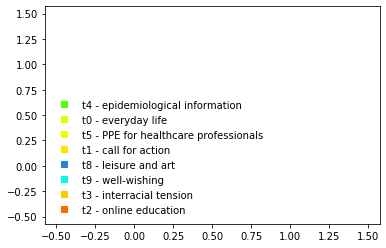

In [127]:
# legend

import matplotlib.pyplot as plt

colors = [topic_colors[topic] for topic in sorted_topics_descending]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(sorted_topics_descending))]
labels = [f't{topic} - {topic_names[topic]}' for topic in sorted_topics_descending]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [176]:
from datetime import datetime

# relative volumes in certain time frames

num_frames = 3

dates = [datetime.strptime(d['date'], '%Y-%m-%dT%H:%M:%S.000Z') for d in df_json]
date_dividers = pd.date_range(min(dates), max(dates), num_frames + 1)

frame_topic_tweet_count = {i: {f't{j}': 0 for j in topics_to_show} for i in range(num_frames)}

for entry in df_json:   
    # which frame is this entry in?
    entry_date = datetime.strptime(entry['date'], '%Y-%m-%dT%H:%M:%S.000Z')
    entry_frame = None
    for i in range(len(date_dividers) - 1):
        if date_dividers[i] <= entry_date < date_dividers[i+1]:
            entry_frame = i
            break
    if entry_frame is None:
        entry_frame = num_frames - 1
    
    frame_topic_tweet_count[entry_frame][entry['series'][:entry['series'].index(':')]] += entry['count']
    
for frame, topic_counts in frame_topic_tweet_count.items():
    print(f'Frame {frame} - {date_dividers[frame]} to {date_dividers[frame+1]}')
    all_counts = sum(topic_counts.values())
    for topic in topic_counts:
        print(f'Percentage for topic {topic}: {topic_counts[topic] / all_counts * 100.0}%')

Frame 0 - 2019-12-31 00:00:00 to 2020-02-22 16:00:00
Percentage for topic t0: 27.002307165285515%
Percentage for topic t1: 30.005737651339633%
Percentage for topic t2: 7.168432749642305%
Percentage for topic t3: 16.862400468695906%
Percentage for topic t4: 16.431955570726842%
Percentage for topic t5: 2.040860792957941%
Percentage for topic t8: 0.36411086982310115%
Percentage for topic t9: 0.12419473152875725%
Frame 1 - 2020-02-22 16:00:00 to 2020-04-16 08:00:00
Percentage for topic t0: 20.218273184950476%
Percentage for topic t1: 32.44485151915538%
Percentage for topic t2: 7.341578659108279%
Percentage for topic t3: 19.10112127766449%
Percentage for topic t4: 18.120428789946356%
Percentage for topic t5: 2.331465396758599%
Percentage for topic t8: 0.2800357703149706%
Percentage for topic t9: 0.1622454021014544%
Frame 2 - 2020-04-16 08:00:00 to 2020-06-09 00:00:00
Percentage for topic t0: 17.29300024998104%
Percentage for topic t1: 36.935541405567555%
Percentage for topic t2: 12.35390855